#### [ML with Python] 3. 비지도 학습 알고리즘 (2-2) 차원축소 : NMF(비음수 행렬 분해)
- 본 포스팅은 NMF에 관한 기본적인 내용에 관하여 다룹니다.
- 비음수 행렬 분해 (`NMF`)
- 고유얼굴(eigenface) 추출 / 음성 신호 추출

___

필요 라이브러리 import

In [31]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
plt.rc('font', family='Malgun Gothic')

In [10]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0~255 사이의 이미지의 픽셀 값을 0~1 사이로 스케일 조정합니다.
# (옮긴이) MinMaxScaler를 적용하는 것과 거의 동일합니다.
X_people = X_people / 255.

X_train, X_test, y_train, y_test = \
train_test_split(X_people, y_people, stratify=y_people, random_state=0)

---

#### <u>비음수 행렬 분해(NMF)</u>

`NMF(Non-negative Matrix Factorization)`
- <u>유용한 특성을 뽑아내기 위한</u> 비지도 학습 알고리즘
- `PCA`와 비슷하며, <u>차원축소에도 사용가능</u>
- `PCA`와 다른 점 : <u>음수가 아닌 성분(즉 양수인 성분)과 계수값을 찾는다.</u>
    - 주성분과 계수가 모두 0보다 크거나 같아야 함
    - 음수가 아닌 특성을 가진 데이터에만 적용 가능
- 용도 : <u>섞여 있는 데이터에서 원본/성분을 구분하는데 사용</u>
    - ex) 시각 처리, 문서 분류, 음파 분석

    
<br>

---

#### <u>NMF 알고리즘 이해하기</u>

`NMF` 알고리즘 이란 <u><b>음수를 포함하지 않은 행렬 V</b>를 음수를 포함하지 않은 </u><b>`가중치 행렬 W`</b><u>와 </u><b>`특성 행렬 H`</b><u>의 곱으로 </u><b>`분해`</b><u>하는 알고리즘이라고 한다.</u>

<br>

나는 `NMF`의 알고리즘에 관한 설명을 듣고 해당 알고리즘이 `분해`를 한다는 것은 알겠지만, "어떻게 분해를 하는 것일까?"에 관하여 궁금증을 느꼈다. 하지만, 이는 아래의 과정들을 통해서 이해할 수 있었다.

<br>

위에서 언급되었던, `가중치 행렬W`와 `특성 행렬H`에 관하여 먼저 이해해보자.

![사진1](https://user-images.githubusercontent.com/53929665/101774181-1794dc00-3b31-11eb-8030-417241ea7f4f.png)


V 행렬로 부터 분해되어 나오는 `가중치 행렬 W`의 행은 <b>특성에 대한 중요도</b>를 의미하며, 열은 <b>데이터의 특성</b>을 의미한다. 이와 반대로, `특성 행렬 H`의 행은 <b>데이터의 특성</b>을 의미하고, 열은 <b>특성에 대한 중요도</b>를 의미한다. 정리하면 다음과 같다.

- W의 열 & H의 행 : 데이터의 특성
- W의 행 & H의 열 : 특성에 대한 중요도

<br>

단순 설명으로는 막연하기 때문에, 예시와 함께 `가중치 행렬 W`와 `특성 행렬 H`에 관하여 살펴보자.
아래와 같이 책에 나온 단어의 빈번도를 나타내는 행렬 v가 있다. 그리고 책과 특성간의 관계를 나타내는 `가중치 행렬 W`, 단어들과 특성간의 관계를 나타내는 `특성 행렬 H`가 있다. 여기서, `W의 성분`은 각 특성이 책에 적합한 정도를 의미하며, `H의 성분`은 각 단어가 특성에서 중요한 정도를 의미한다.

![사진2](https://user-images.githubusercontent.com/53929665/101774876-07c9c780-3b32-11eb-802b-80f471999581.png)


아주 조금 더 깊게 설명하면 다음과 같다.

- 예시 `가중치 행렬 W` : 책과 특성간의 관계
    - 각 열에서 값이 높은 책이 해당 `특성`을 대표하는 책임을 뜻한다.
    - 각 행에서 값이 높은 `특성`이 해당 책을 대표하는 특성임을 뜻한다.
- 예시 `특성 행렬W` : 단어들과 특성간의 관계
    - 각 행에서 값이 높은 단어가 해당 `특성`을 대표하는 단어임을 뜻한다.
    
여기서, `특성`에 따라서, 대표하는 무언가가 달라지는 것을 확인할 수 있으며, 이는 `특성의 개수`에 따라서도 분류에 영향이 있음을 의미한다.

<br>

그렇다면, `V`행렬을 어떻게 `가중치 행렬 W`와 `특성 행렬 H`행렬로 분해하는 것일까? 내 기준에서는 아직까지 `n*m 행렬을 n*r행렬과 r*m 행렬로 분해하는 방법`에 관한 지식이 없어서 이 부분이 가장 의아했다. 하지만, 원리는 의외로 단순하였다.

<br>

`NMF`의 분해 로직은 처음에 `가중치 행렬 W`와 `특성 행렬H`에 임의의 값을 채우고 이 두 행렬을 곱한 결과가 기존 행렬 `V`에 근사할 때 까지 반복하는 것이다. <u>그리고 이것은 결과적으로 행렬하나를 두 개의 행렬로 분해하는 것과 유사하다.</u>

![사진3](https://user-images.githubusercontent.com/53929665/101776877-f6ce8580-3b34-11eb-8412-4c7c41048f06.png)


<br>

이제 실제 데이터에 적용하고 확인하면서 이해해보자

<br>

---

#### <u> 인위적 데이터에 NMF 적용하기</u>

`PCA`를 사용할 때와 달리 `NMF`로 데이터를 다루려면 앞에서 확인했던거와 같이 주어진 데이터가 양수인지 확인할 필요가 있다. 즉, <u>데이터가 원점 (0, 0)에서 상대적으로 어디에 놓여있는지</u>가 `NMF`에서 중요하다는 의미이다.

C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


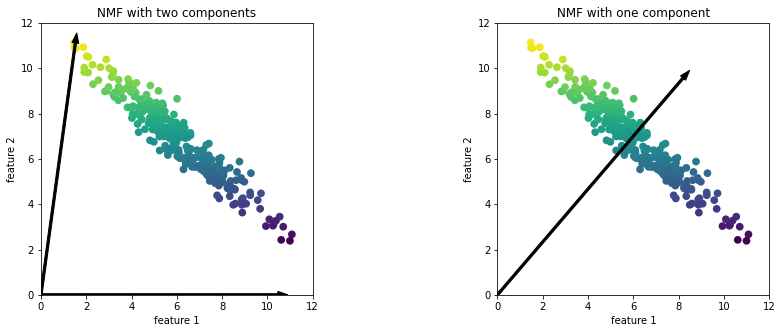

In [3]:
mglearn.plots.plot_nmf_illustration()

위의 그림에서 왼쪽은 `특성`이 2개일 때, 오른쪽은 `특성`이 1개일 때를 보여준다. 데이터셋의 모든 포인트를 양수로 이뤄진 두 개의 성분으로 표현할 수 있다. 또한, 특성의 갯수는 분류에 영향을 준다는 것을 위에서 확인하였었다. 따라서, 특성이 아주 많다면 알고리즘은 데이터의 각 특성의 끝에 위치한 포인트를 가리키는 방향을 선택할 것이다. 하지만, 하나의 성분만을 사용한다면 `NMF`는 데이터를 가장 잘 표현할 수 있는 평균으로 향하는 성분을 만든다.

<br>

---

#### <u>얼굴 이미지에 NMF 적용하기</u>

이전 `PCA`에서 사용한 `LFW` 데이터셋에 `NMF`를 적용해보자. `NMF`의 핵심 매개변수는 `추출할 성분의 개수`이다. 보통 이 값은 데이터셋이 가진 특성(ex. 웹사이트를 이용하는 유저의 성별, 나이 등등)의 개수보다 작다.

<br>

`NMF`를 사용해 데이터를 재구성하는 데 `성분의 개수`가 어떤 영향을 주는지 확인해보자

________________________________________________________________________________
[Memory] Calling mglearn.plot_nmf.nmf_faces...
nmf_faces(array([[0.539869, ..., 0.243137],
       ...,
       [0.043137, ..., 0.593464]], dtype=float32), 
array([[0.237908, ..., 0.267974],
       ...,
       [0.401307, ..., 0.254902]], dtype=float32))


C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  

______________________________________________________nmf_faces - 309.3s, 5.2min


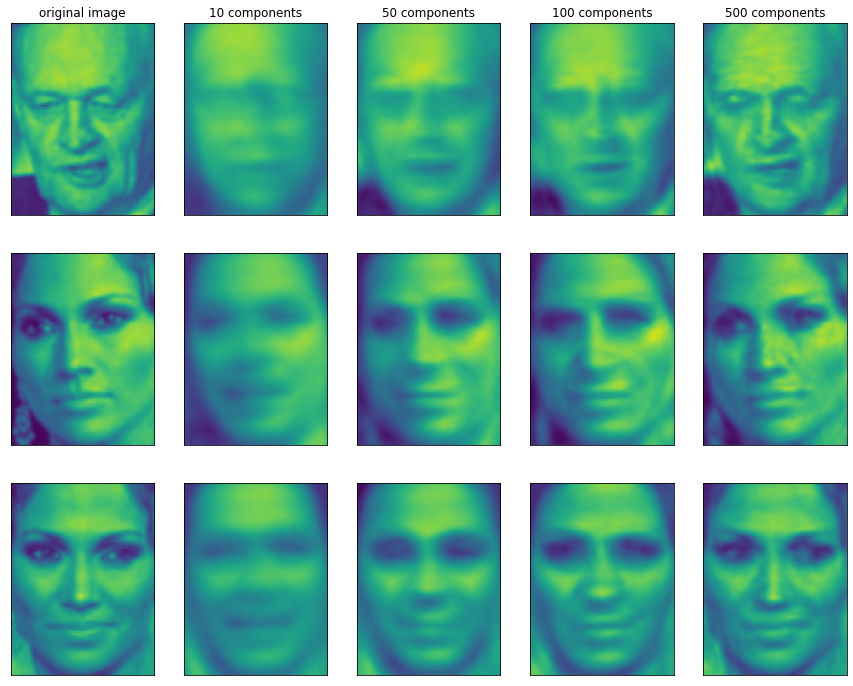

In [11]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

`PCA`보다는 품질이 조금 떨어지는 것을 확인할 수 있다. 왜냐하면 `PCA`는 재구성 측면에서 최선의 방향을 찾는 반면에 `NMF`는 맨 처음에 확인했듯이 `유용한 패턴(혹은 특성)`을 찾는데 활용한다(재구성하는 용도로는 `PCA`보다 뒤떨어지기 때문에 `NMF`로 재구성을 굳이 수행하지 않는다).

<br>

성분 15개를 추출하여 `유용한 패턴`이란게 있는지 아래에서 확인할 수 있다.
- component 3 : 오른쪽으로 조금 회전한 얼굴 패턴
- component 7 : 왼쪽으로 조금 회전한 얼굴 패턴

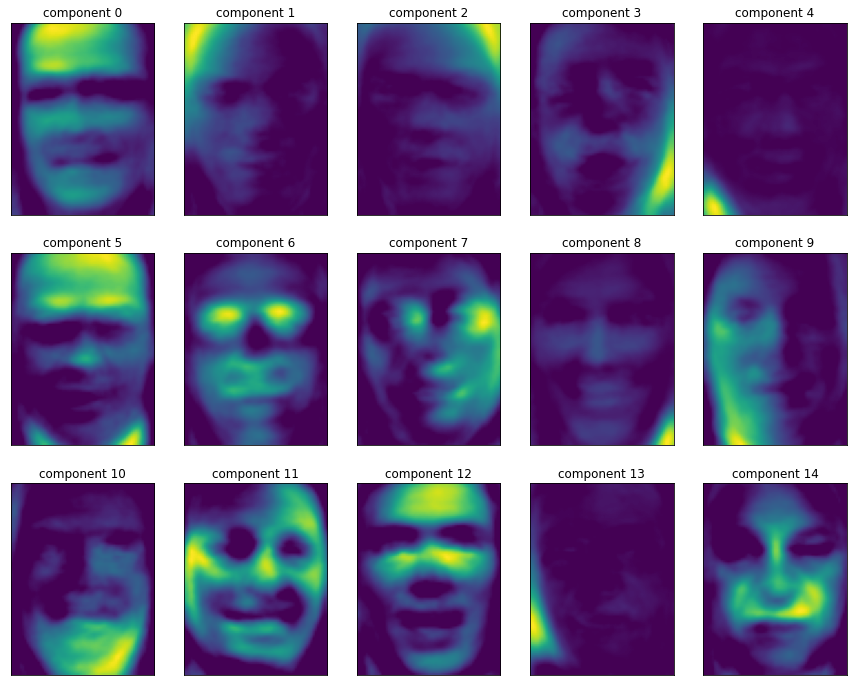

In [17]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0, max_iter=1000, tol=1e-2)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("component {}".format(i))

이 성분들이 특별히 강하게 나타난 이미지를 추출하면 다음과 같다.

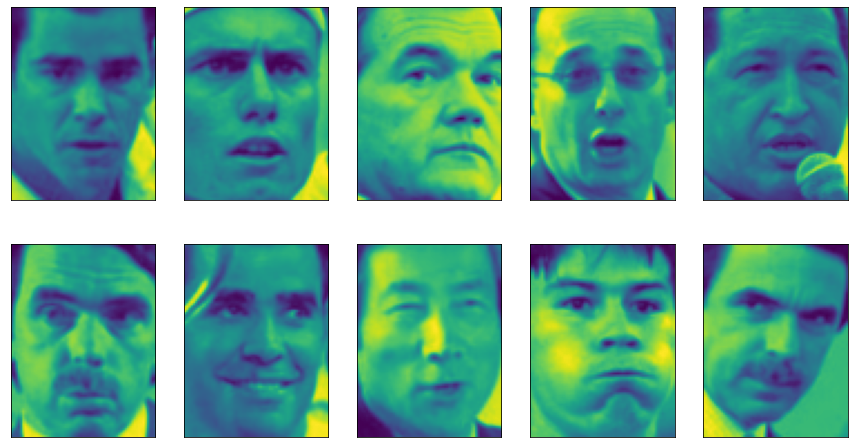

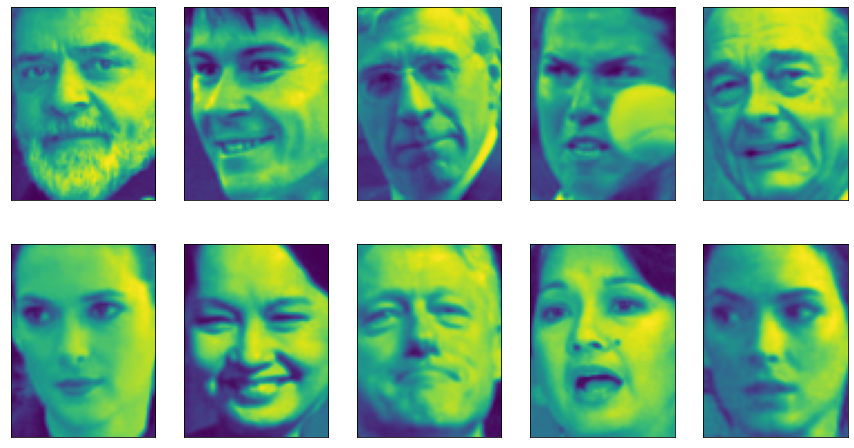

In [18]:
compn = 3
# 4번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
    
compn = 7
# 8번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

<br>

이와 같은 패턴을 추출하는 것은 소리, 유전자 표현, 텍스트 데이터처럼 덧붙이는 구조를 가진 데이터에는 `NMF` 알고리즘이 적합한다. 인위적인 데이터셋을 이용한 예에서 이에 관해 확인해보자. 다음은 세 개의 서로 다른 입력으로부터 합성된 신호이다.

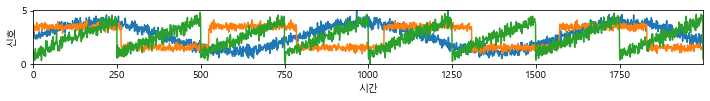

In [52]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(12, 1))
plt.plot(S, '-')
plt.xlabel("시간")
plt.ylabel("신호")
plt.margins(0)

여기서 합쳐진 신호를 `분해`해서 원본 신호를 복원해야하는 상황에 처해있으며 이 신호를 100개의 측정 장치로 측정하고 각 측정 장치는 측정 데이터를 제공한다고 가정하자.

In [35]:
# 원본 데이터를 사용해 100개의 측정 데이터를 만듭니다
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("측정 데이터 형태:", X.shape)

측정 데이터 형태: (2000, 100)


In [29]:
# 비교용 PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)

In [36]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("복원한 신호 데이터 형태:", S_.shape)

복원한 신호 데이터 형태: (2000, 3)


C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


<br>

아래의 그림에서 `NMF`와 `PCA`로 찾은 신호를 나타내었다.
- 측정 신호(처음 3개) : 

C:\Users\jhryu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


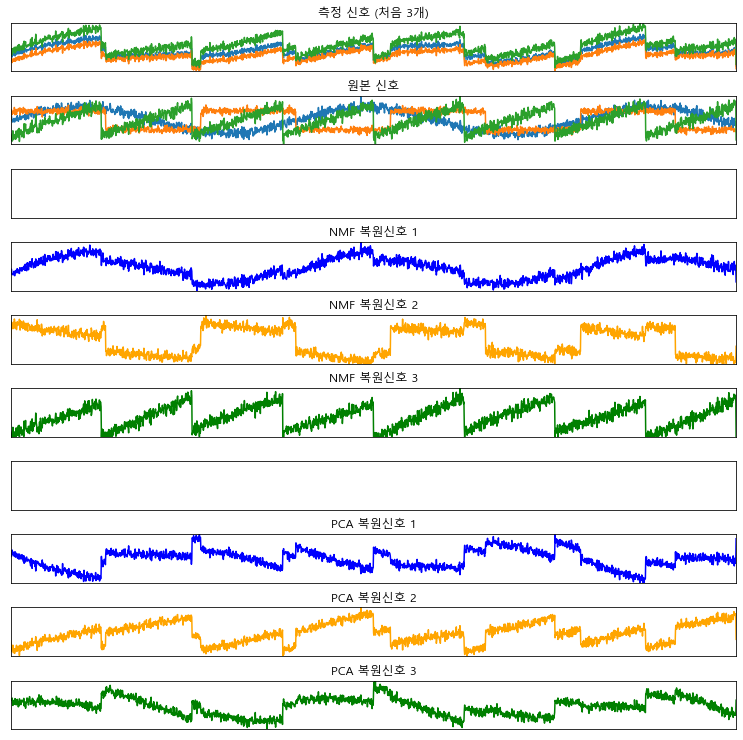

In [100]:
models = [X, S, S_]
names = ['측정 신호 (처음 3개)', '원본 신호', '공란']

fig, axes = plt.subplots(10, figsize=(13, 13), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes[0:2]):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')
    ax.margins(0)

nmf_model = [S_[:, :1], S_[:, 1:2], S_[:, 2:3]]
nmf_title = ['NMF 복원신호 1', 'NMF 복원신호 2', 'NMF 복원신호 3', '공란']
colors = ['blue', 'orange', 'green']

for model, name, ax, colors in zip(nmf_model, nmf_title, axes[3:7], colors):
    ax.set_title(name)
    ax.plot(model, '-', color = colors)
    ax.margins(0)
    
nmf_model = [H[:, :1], H[:, 1:2], H[:, 2:3]]
nmf_title = ['PCA 복원신호 1', 'PCA 복원신호 2', 'PCA 복원신호 3']
colors = ['blue', 'orange', 'green']

for model, name, ax, colors in zip(nmf_model, nmf_title, axes[7:10], colors):
    ax.set_title(name)
    ax.plot(model, '-', color = colors)
    ax.margins(0)
    
plt.tight_layout()
plt.show()

`NMF`는 원본 신호를 잘 추출하여 복원한 반면 `PCA`는 실패했음을 확인할 수 있다.

<br>

---

### References

- 안드레아스 뮐러, 세라 가이도, 『파이썬 라이브러리를 활용한 머신러닝』, 박해선, 한빛미디어(2017)
- 위키백과 : 음수_미포함_행렬_분해